# 4. Model Assembling

In [1]:
import os
os.chdir('.\\data')
print(os.getcwd())

D:\MAFM\MAFM-3\5440\project1\data


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from numpy.random import randint
from multiprocessing import cpu_count
import os
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
# !pip install mlens
# !pip install scikit-learn-intelex
# !pip install imblearn

In [4]:
from sklearn.linear_model import LogisticRegression ,SGDClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline #pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE #for feature selection
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import (f1_score,classification_report,
                             roc_auc_score,confusion_matrix,roc_curve,auc) # evaluatin metrics
from sklearn.model_selection import KFold,RandomizedSearchCV ,cross_val_score,RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import gc

In [5]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## 4.1 Import Data

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)


    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True, compression='zip', index_col=0)
    df = reduce_mem_usage(df)
    return df

In [7]:
application_train = import_data('features_train.csv')
application_test = import_data('features_test.csv')

Memory usage of dataframe is 1839.36 MB
Memory usage after optimization is: 663.07 MB
Decreased by 64.0%
Memory usage of dataframe is 291.56 MB
Memory usage after optimization is: 99.81 MB
Decreased by 65.8%


In [8]:
application_test = application_test.drop('TARGET', axis=1)
print(application_train.shape)
print(application_test.shape)

(307511, 783)
(48744, 782)


In [9]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_ANNUITY_to_prev_approved,AMT_ANNUITY_to_prev_refused,AMT_CREDIT_to_prev_approved,AMT_CREDIT_to_prev_refused,AMT_PAY_YEAR_to_prev_approved,AMT_PAY_YEAR_to_prev_refused,AMT_DIFF_CREDIT_GOODS_to_prev_approved,AMT_DIFF_CREDIT_GOODS_to_prev_refused,AMT_CREDIT_GOODS_PERC_to_prev_approved,AMT_CREDIT_GOODS_PERC_to_prev_refused
0,100002,1.0,0,0,0,0,0,202500.0,406597.5,24700.5,...,1.669812,NaN,1.270797,NaN,-0.149414,NaN,inf,NaN,0.158447,NaN
1,100003,0.0,0,1,0,1,0,270000.0,1293502.5,35698.5,...,-0.368771,NaN,18.007141,NaN,3.175781,NaN,2.363843,NaN,0.082764,NaN
2,100004,0.0,1,0,1,0,0,67500.0,135000.0,6750.0,...,0.259975,NaN,5.714414,NaN,4.328125,NaN,-1.000000,NaN,0.207642,NaN
3,100006,0.0,0,1,0,0,0,135000.0,312682.5,29686.5,...,0.359136,-0.092048,0.668681,NaN,-0.332275,-0.620117,-2.837011,-0.9281,0.106018,-0.200439
4,100007,0.0,0,0,0,0,0,121500.0,513000.0,21865.5,...,0.780752,NaN,2.078516,NaN,0.855469,NaN,-1.000000,NaN,-0.044312,NaN


In [10]:
def make_valid_column_name(s):
        s = str(s).strip()
        s = re.sub(r'[^0-9a-zA-Z_]+', '_', s)
        s = re.sub(r'^(?=\d)', '_', s)
        if s in dir(__builtins__):
            s += '_'
        return s

application_train.columns = [make_valid_column_name(col) for col in application_train.columns]
application_test.columns = [make_valid_column_name(col) for col in application_test.columns]

## 4.2 Data Cleaning

In [11]:
application_train['CODE_GENDER'].replace('XNA',np.nan,inplace=True)
application_test['CODE_GENDER'].replace('XNA',np.nan,inplace=True)

In [12]:
FLAG_DOCUMENT=[
'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_13', 
'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 
'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 
'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']
application_train['FLAG_DOCUMENT']=application_train[FLAG_DOCUMENT].sum(axis=1)
application_test['FLAG_DOCUMENT']=application_test[FLAG_DOCUMENT].sum(axis=1)
application_train.drop(FLAG_DOCUMENT,axis=1,inplace=True)
application_test.drop(FLAG_DOCUMENT,axis=1,inplace=True)

In [13]:
# Age Feature
application_train['AGE']=application_train['DAYS_BIRTH']/(-365)
application_test['AGE']=application_test['DAYS_BIRTH']/(-365)
# MEAN_EXT_SOURCE
application_train['MEAN_EXT_SOURCE'] = application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
application_test['MEAN_EXT_SOURCE'] = application_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
# YEARS_EMPLOYED
application_train['YEARS_EMPLOYED']=application_train['DAYS_EMPLOYED']/(-365)
application_test['YEARS_EMPLOYED']=application_test['DAYS_EMPLOYED']/(-365)
# DAYS_BIRTH_SQUARED
application_train['DAYS_BIRTH_SQUARED'] = application_train['DAYS_BIRTH'] ** 2
application_test['DAYS_BIRTH_SQUARED'] = application_test['DAYS_BIRTH'] ** 2
# DEBT_TO_INCOME_RATIO 
application_train['DEBT_TO_INCOME_RATIO'] = application_train['AMT_CREDIT'] / application_train['AMT_INCOME_TOTAL']
application_test['DEBT_TO_INCOME_RATIO'] = application_test['AMT_CREDIT'] / application_test['AMT_INCOME_TOTAL']
# INCOME_TO_CREDIT 
application_train['INCOME_TO_CREDIT'] = application_train['AMT_INCOME_TOTAL'] / application_train['AMT_CREDIT']
application_test['INCOME_TO_CREDIT'] = application_test['AMT_INCOME_TOTAL'] / application_test['AMT_CREDIT']

In [14]:
application_train['_INCOME_CLASS']=pd.qcut(application_train['AMT_INCOME_TOTAL'],3,labels=['Low_INCOME', 'Medium_INCOME', 'High_INCOME'])
application_train['ANNUITY_CLASS']=pd.qcut(application_train['AMT_ANNUITY'],3,labels=['Low_ANNUITY', 'Medium_ANNUITY', 'High_ANNUITY'])
application_train['DAYS_BIRTH_CLASS']=np.where(application_train['DAYS_BIRTH']<-15000,1,0)
application_train['CREDIT_UNDER_100K']=np.where(application_train['AMT_CREDIT']<100000,1,0)
application_train['YEARS_EMPLOYED_CLASS']=np.where(application_train['DAYS_EMPLOYED']<100000,1,0)

application_test['_INCOME_CLASS']=pd.qcut(application_test['AMT_INCOME_TOTAL'],3,labels=['Low_INCOME', 'Medium_INCOME', 'High_INCOME'])
application_test['ANNUITY_CLASS']=pd.qcut(application_test['AMT_ANNUITY'],3,labels=['Low_ANNUITY', 'Medium_ANNUITY', 'High_ANNUITY'])
application_test['DAYS_BIRTH_CLASS']=np.where(application_test['DAYS_BIRTH']<-15000,1,0)
application_test['CREDIT_UNDER_100K']=np.where(application_test['AMT_CREDIT']<100000,1,0)
application_test['YEARS_EMPLOYED_CLASS']=np.where(application_test['DAYS_EMPLOYED']<100000,1,0)

In [15]:
AMT_REQ_CREDIT=['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY',
                'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT']
application_train.drop(AMT_REQ_CREDIT,axis=1,inplace=True)
application_test.drop(AMT_REQ_CREDIT,axis=1,inplace=True)

In [16]:
SK_ID_CURR=application_test["SK_ID_CURR"]
application_test.drop('SK_ID_CURR',inplace=True,axis=1)
SK_ID_CURR_TRAIN=application_train["SK_ID_CURR"]
application_train.drop('SK_ID_CURR',inplace=True,axis=1)

In [17]:
# Detect highly missing numeric features 
application_train_numeric= application_train.select_dtypes(include=['number'])
missings=application_train_numeric.loc[:,application_train_numeric.isna().mean() >= 0.6]
highly_missing_features = missings.columns
missings.columns
#Remove highly missing features
application_train.drop(highly_missing_features,axis=1,inplace=True)
application_test.drop(highly_missing_features,axis=1,inplace=True)

In [18]:
target = application_train['TARGET']
features_train = application_train.drop('TARGET', axis=1)

numeric_imputer = SimpleImputer(strategy='median')

numeric_features_train = features_train.select_dtypes(include='number')
numeric_features_test = application_test.select_dtypes(include='number')

numeric_features_train.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_features_test.replace([np.inf, -np.inf], np.nan, inplace=True)


imputed_numeric_features_train = numeric_imputer.fit_transform(numeric_features_train)
imputed_numeric_features_test = numeric_imputer.transform(numeric_features_test)

In [19]:
categorical_features_train = features_train.select_dtypes(include='object')
# using dummy_na=False ,we perform onehot encoding without affecting data distribution
dummy_categorical_features_train = pd.get_dummies(categorical_features_train,dummy_na=False)

# Concatenate imputed numerical and categorical features Train
imputed_features_train = pd.concat([pd.DataFrame(imputed_numeric_features_train, columns=numeric_features_train.columns),
                              dummy_categorical_features_train] ,axis=1)

# Impute categorical features Test using mode imputation and one-hot encoding
categorical_features_test = application_test.select_dtypes(include='object')
dummy_categorical_features_test = pd.get_dummies(categorical_features_test,dummy_na=False)
missing_columns = set(dummy_categorical_features_train.columns) - set(dummy_categorical_features_test.columns.get_level_values(0))
for col in missing_columns:
    dummy_categorical_features_test[col] = 0
dummy_categorical_features_test = dummy_categorical_features_test[dummy_categorical_features_train.columns]

# Concatenate imputed numerical and categorical features
imputed_features_test = pd.concat([pd.DataFrame(imputed_numeric_features_test, columns=numeric_features_test.columns),
                              dummy_categorical_features_test],
                             axis=1)

In [20]:
X=imputed_features_train.copy()
print(X.dtypes)
categorical_features_indices = np.where(X.dtypes != float)[0]

NAME_CONTRACT_TYPE                                                                float64
CODE_GENDER                                                                       float64
FLAG_OWN_CAR                                                                      float64
FLAG_OWN_REALTY                                                                   float64
CNT_CHILDREN                                                                      float64
                                                                                   ...   
bureau_CREDIT_TYPE_mode_sum_CREDIT_TYPE_Loan for working capital replenishment      uint8
bureau_CREDIT_TYPE_mode_sum_CREDIT_TYPE_Microloan                                   uint8
bureau_CREDIT_TYPE_mode_sum_CREDIT_TYPE_Mortgage                                    uint8
bureau_CREDIT_TYPE_mode_sum_CREDIT_TYPE_Real estate loan                            uint8
bureau_CREDIT_TYPE_mode_sum_CREDIT_TYPE_Unknown type of loan                        uint8
Length: 60

In [21]:
y=target

X.fillna(-9999, inplace=True)
y.fillna(-9999, inplace=True)

#splitting data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.1, random_state=27)

In [22]:
imputed_features_test.fillna(-9999, inplace=True)
imputed_features_train.fillna(-9999, inplace=True)

## 4.3 Model Enssembling

In [23]:
# A host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from lightgbm import LGBMClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline
SEED=42

def get_models():
    lr = LogisticRegression(C=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)
    lgb = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=SEED)


    models = {
#         'svm': svc,
#         'knn': knn,
#         'naive bayes': nb,
#         'mlp-nn': nn,
        'lightgbm': lgb,
        'random forest': rf,
        'logistic': lr,
        
             }

    return models


def train_predict(model_list):
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(X_train, y_train)
        P.iloc[:, i] = m.predict_proba(X_test)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y_test, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [24]:
models = get_models()
P = train_predict(models)

Fitting models.
lightgbm... done
random forest... done
logistic... done
Done.



In [25]:
def score_models(P, y):
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y_test, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")
    
score_models(P, y_test)

Scoring models.
lightgbm                  : 0.797
random forest             : 0.635
logistic                  : 0.554
Done.



## 4.4 Results

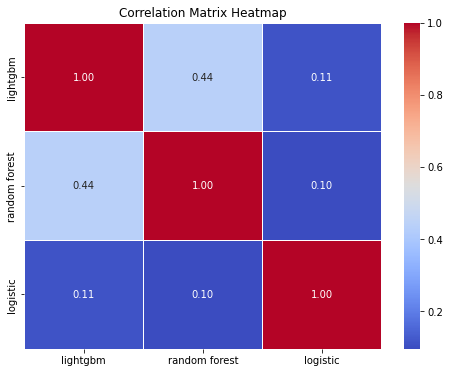

In [26]:
# correlation analysis
corr_matrix = P.corr()

plt.figure(figsize=(8, 6))  
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [27]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(y_test, P.mean(axis=1)))

Ensemble ROC-AUC score: 0.733


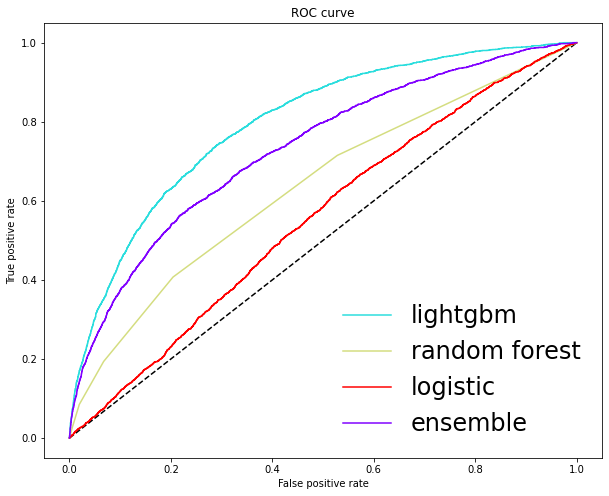

In [42]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
#"""Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')

    cm = [plt.cm.rainbow(i)
    for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]

    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False, fontsize=24)
    plt.show()


plot_roc_curve(y_test, P.values, P.mean(axis=1), list(P.columns), "ensemble")

In [29]:
include = [c for c in P.columns if c not in ["knn"]]
print("Truncated ensemble ROC-AUC score: %.3f" % roc_auc_score(y_test, P.loc[:, include].mean(axis=1)))

Truncated ensemble ROC-AUC score: 0.733


In [30]:
base_learners = get_models()
meta_learner = GradientBoostingClassifier(
   n_estimators=1000,
   loss="exponential",
   max_features=4,
   max_depth=3,
   subsample=0.5,
   learning_rate=0.005, 
   random_state=SEED
)
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(X_train, y_train, test_size=0.5, random_state=SEED)

In [31]:
def train_base_learners(base_learners, inp, out, verbose=True):
#"""Train all base learners in the library."""
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: 
            print("%s..." % name, end=" ", flush=False)
            m.fit(inp, out)
    if verbose: print("done")

In [32]:
train_base_learners(base_learners, xtrain_base, ytrain_base)

Fitting models.
lightgbm... random forest... logistic... done


In [33]:
def predict_base_learners(pred_base_learners, inp, verbose=True):
#"""Generate a prediction matrix."""
    P = np.zeros((inp.shape[0], len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: 
            print("%s..." % name, end=" ", flush=False)
            p = m.predict_proba(inp)
    # With two classes, need only predictions for one class
            P[:, i] = p[:, 1]
    if verbose: print("done")

    return P

In [34]:
P_base = predict_base_learners(base_learners, xpred_base)

Generating base learner predictions.
lightgbm... random forest... logistic... done


In [35]:
meta_learner.fit(P_base, ypred_base)

GradientBoostingClassifier(learning_rate=0.005, loss='exponential',
                           max_features=4, n_estimators=1000, random_state=42,
                           subsample=0.5)

In [36]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

In [37]:
P_pred, p = ensemble_predict(base_learners, meta_learner, X_test)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(y_test, p))

Generating base learner predictions.
lightgbm... random forest... logistic... done

Ensemble ROC-AUC score: 0.792


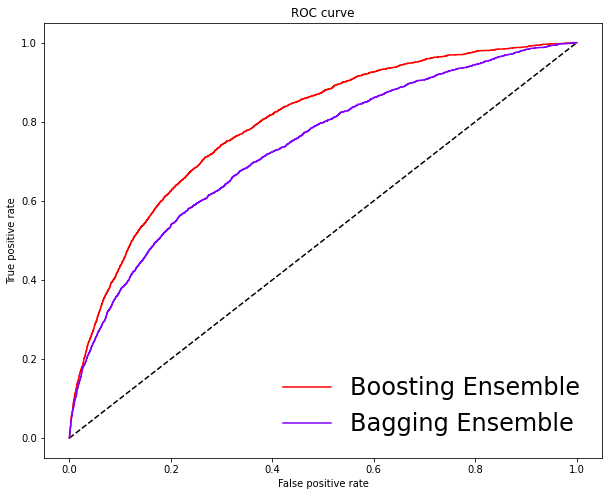

In [43]:
# compare bagging & boosting ensemble
plot_roc_curve(y_test, p.reshape(-1, 1), P.mean(axis=1), ["Boosting Ensemble"], "Bagging Ensemble") 